<h1 style="font-size:2em;color:#2467C0">🌌 უსასრულო გალაკტიონი</h1>

In [1]:
# read it in to inspect it
with open('galaktioni.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  922495


In [3]:
# let's look at the first 1000 characters
print(text[:500])

***
„აი - ია“

აგერ პატარა შკოლა,
მთა აფხაზეთის სოფლის,
მის წინ ხეები ჩქოლა
და დარიგება მშობლის.

ვერ გადაუდგამს ბიჯი,
შიგნით კი ხმაურს ჰქვია -
ყდაზე ნახატი ბიჭი
და ხმები: „აი - ია“.

***
„ჩარდა ამთა“

სადღეგრძელოსთვის სიტყვის თქმის ნება მომეცი, თამადა:
შემკობად თინათინისა ამ სასმისს ვსვამ თამამადა,
ვის მკერდზე გადმოფენია ნაწნავი ცხრა სამ-სამადა,
ვისი თავხურვა ყოველგვარ თავხურვას შეეკამათა,
და წარბ-წამწამი ყველასი არ ღირს მის წარბ-წამწამათა,
სახის კანს სადაფისფერსა მზემ შუქი რამ მიამატა,
ტანსარო


In [4]:
# Check all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

	
 !"'()*,-.0123456789:;<>?ABCDEFGIKLMNOPRSTVX[]_abcdefghilmnoprstuvxzʼБфაბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰჲ–—‘’“”„…
115


In [ ]:
# Encode the entire text dataset and store it into a torch.Tensor
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100]) # the 1000 characters we looked at earier will to the GPT look like this

In [10]:
# Split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [11]:
block_size = 8
train_data[:block_size+1]

tensor([  8,   8,   8,   1, 113,  73,  81,   2,  10])

In [12]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([8]) the target: 8
when input is tensor([8, 8]) the target: 8
when input is tensor([8, 8, 8]) the target: 1
when input is tensor([8, 8, 8, 1]) the target: 113
when input is tensor([  8,   8,   8,   1, 113]) the target: 73
when input is tensor([  8,   8,   8,   1, 113,  73]) the target: 81
when input is tensor([  8,   8,   8,   1, 113,  73,  81]) the target: 2
when input is tensor([  8,   8,   8,   1, 113,  73,  81,   2]) the target: 10


# Build a Model

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [8]:
# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 512 # what is the maximum context length for predictions?
max_iters = 10000
eval_interval = 100
learning_rate = 0.0001
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
eval_iters = 200
n_embd = 512 # embedding dimension
n_head = 8 # number of heads (512/8 = 64 dimensions per head)
n_layer = 6
dropout = 0.2

In [9]:
torch.manual_seed(1337)

In [10]:
# read it in to inspect it
with open('galaktioni.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [11]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [12]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [13]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [14]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [15]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [16]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [17]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [18]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [19]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [20]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

19.286131 M parameters


In [ ]:
# Create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
save_interval = 100

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Append losses to lists for plotting
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    
    # Save the model's state at the specified interval
    if (iter + 1) % save_interval == 0:
        checkpoint = {
            'epoch': iter + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }
        torch.save(checkpoint, f'model_checkpoint_{iter + 1}.pth')

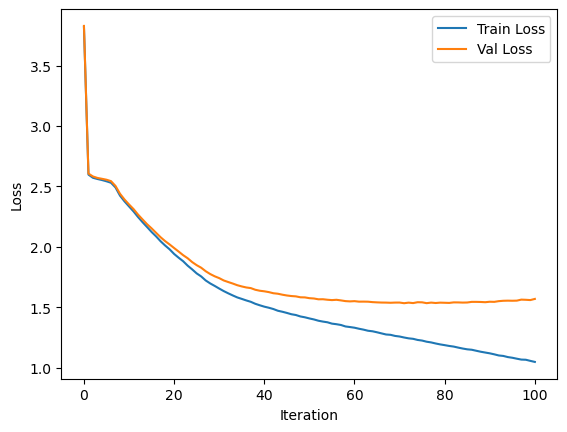

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

	ორც ლაჟვარდ ჩუქურთმა გროვილთ გავეყრება, თოვილი,
სიხარე დღეების ფიქრობს, სიყვარცეებს უქნებელი,
მათ ვნებით ტყეებშია შეუგებელად ვიგრძენ - რომაშის,
ვეძებ უსხით სიყვარულის სიდია ჩრდილით ჩვეული.
ვართ ტყეები და ირგვლივ ყველა იმაპოვნებს ხელით,
მაგრამ მის სხივებით დაირგვება ეგ ოცნება ჩვენს ყრმის ხუმრებს,
მთვარე ნაზი ღარ ისევ დაგდნობით იქნებს ორ ღამეს?

მთისად, კმაროდებში არსებობს მარმარტოკა მკვდრენ სახეს -
მხრიდან ნელი და მთისადმორად ბრძოლებში არ მაგონებს, ვერცხლისა
და ვერც ისე ცოცხლისფერ ნათელით თვალთზე ჩუქები არსად...

***
მარმარედ...

მარმარილოს პარიკი,
დაუდგე ბედი ღამის ბინა
ხუთწლედი სიცოცხლის წერდი,
გთხოვს ამშვენიერზე ბედისასწერდი.
გამომაძახე ისე და ბინდის,
ამირწყინოს ყოფიდან ნამდვილი,
მშვენიერებდით ხანისწერდი!
ღამის ჩაუვალ მზიანი და
ღამის ბიბინა ბიში,
თეატრის კიდეც რიოდი.

***
მარმარილოს დღეში,

მარიომ კიდევ მზე
დაფიქრებულ ნავერი,
როგორც ეს ს ბედისწერა
პოეზიის დღეები,
მზე მიდის მღერის მთები
დემონიუსეი.
თუ ერთი სიმისი თოვა
ყვავილს იბინდებად ქლავს,
არამედ მაშინ ისრით
მარღალოს პირველ ხმის
ვ

#### Save the Model

In [49]:
# Specify the file path for saving the model
model_path = 'model_checkpoint.pth'

# Save the model and optimizer state
checkpoint = {
    'model_state_dict': m.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(checkpoint, model_path)

#### Load the Model

In [47]:
# Load the model and optimizer state from the saved checkpoint
checkpoint = torch.load('model_checkpoint.pth')
m.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
m.to(device)
m.eval()

BigramLanguageModel(
  (token_embedding_table): Embedding(115, 512)
  (position_embedding_table): Embedding(512, 512)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (key): Linear(in_features=512, out_features=64, bias=False)
            (query): Linear(in_features=512, out_features=64, bias=False)
            (value): Linear(in_features=512, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_aff

###  Run Infinite Loop

In [74]:
# Set up the initial context for generation
context = torch.zeros((1, 1), dtype=torch.long, device=device)

# Infinite text generation loop
while True:
    generated_tokens = model.generate(context, max_new_tokens=1)[0].tolist()
    generated_text = decode(generated_tokens)
    print(generated_text, end='', flush=True)  # Print generated text without newline and flush buffer
    # Update the context for next iteration
    context = torch.tensor(generated_tokens, dtype=torch.long, device=device).unsqueeze(0)

	 	 კ	 კი	 კის	 კისე	 კისენ	 კისენ 	 კისენ ს	 კისენ სა	 კისენ საჰ	 კისენ საჰხ	 კისენ საჰხს	 კისენ საჰხსო	 კისენ საჰხსოვ	 კისენ საჰხსოვს	 კისენ საჰხსოვს 	 კისენ საჰხსოვს ზ	 კისენ საჰხსოვს ზღ	 კისენ საჰხსოვს ზღვ	 კისენ საჰხსოვს ზღვა	 კისენ საჰხსოვს ზღვა:	 კისენ საჰხსოვს ზღვა: 	 კისენ საჰხსოვს ზღვა: დ	 კისენ საჰხსოვს ზღვა: დი	 კისენ საჰხსოვს ზღვა: დის	 კისენ საჰხსოვს ზღვა: დისმ	 კისენ საჰხსოვს ზღვა: დისმე	 კისენ საჰხსოვს ზღვა: დისმენ	 კისენ საჰხსოვს ზღვა: დისმენ 	 კისენ საჰხსოვს ზღვა: დისმენ მ	 კისენ საჰხსოვს ზღვა: დისმენ მო	 კისენ საჰხსოვს ზღვა: დისმენ მოი	 კისენ საჰხსოვს ზღვა: დისმენ მოის	 კისენ საჰხსოვს ზღვა: დისმენ მოისპ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპე	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შე	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი	 კისენ საჰ

	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
რ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
რო	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგო	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც 	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამ

გამოდის ალერს	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეული მოსვლა.
გამოდის ალერსი	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეული მოსვლა.
გამოდის ალერსის	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეული მოსვლა.
გამოდის ალერსის 	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეული მოსვლა.
გამოდის ალერსის ზ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გ

მშვენიერი, მშვენიერ, ქუჩი	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეული მოსვლა.
გამოდის ალერსის ზენაა,
მშვენიერი, მშვენიერ, ქუჩი!	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეული მოსვლა.
გამოდის ალერსის ზენაა,
მშვენიერი, მშვენიერ, ქუჩი!
	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეული მოსვლა.
გამოდის ალერსის ზენაა,
მშვენიერი, მშვენიერ, ქუჩი!
ბ	 კისენ საჰხსოვს ზღვა: დისმენ მოისპენს,
შენი ოხვრა, გზა და მიეცენ თოვლში
ჩამავალ არგონს გაშლება სული.
ჩამალახების გონებით ნაჩს,
როგორც ახალი წელიწადს შელლია,
ტალღები ალერსით გადაიწევს
ჟრუტინგში არეუ

KeyboardInterrupt: 

#### Manual Context

In [53]:
# Manually input the initial context
initial_text = input("სათაური:")
initial_tokens = encode(initial_text)  # Using the 'encode' function to convert text to tokens

# Convert the initial context tokens to a tensor and unsqueeze to match expected shape (B, T)
initial_context_tensor = torch.tensor(initial_tokens, dtype=torch.long, device=device).unsqueeze(0)

# generate from the model
print(decode(m.generate(initial_context_tensor, max_new_tokens=512)[0].tolist()))

სათაური:საქართველო
საქართველოს ვარსკვლავე,
ვარსკვლავე, მეხობით ვნახე, ტკბილი მთა მოჰკლავდა!
ო, რა არის მოჰყვე, რა და გიშვე ჭალები,
გიშველებიან, საკმარქველო და გიშველები.

***
ტკბილი

შორ გუგუნების წიგნი - ხან იქით - ჩქარი -
ყორანი, სადაც მიკვდა, ყორანი
იქით, ვით თოვლი.. ორი ირხით დარიგა, -
ორემ რა დაიძრა ცეცხლი გადანი,
მხრები გედით დაიქანა სალ კამებით
და დაიძრა ანთოსი სული აგებეს -
სალამა რწმენა დაიმსხვრეს შორის მტატისტს.

***
ტკბილობით რიმი

ყორად სილაჟვარდე თითქო ილდის
რკინის მობილობს ხელოვნება,
თითქო მაღელვარე გადაგრილი,
გუბი კაკლტუ
